### DECISION TREE CLASSIFIER
In this assignment we will try to predict whether a vehicle is deemed accpetable or unacceptable depending upon factors such as maintenance, number of doors, safety, etc.

In [12]:
# DECISION TREE CLASSIFIER
import pandas as pd
import matplotlib.pyplot as plt

# Define constants
COUNT_THRESHOLD = 5  # Count threshold for labeling a node as a leaf
MAX_DEPTH = 3  # Maximum depth for the decision tree

In [13]:
# Function 1: Calculate Gini Impurity
def calculate_gini(data):
    labels = [row[-1] for row in data]
    total = len(labels)
    if total == 0:
        return 0
    counts = {}
    for label in labels:
        counts[label] = counts.get(label, 0) + 1
    gini = 1 - sum((count / total) ** 2 for count in counts.values())
    return gini


In [14]:
# Function 2: Split dataset by an attribute
def split_data(data, attribute_index, value):
    return [row for row in data if row[attribute_index] == value]


In [15]:
# Function 3: Calculate Gini Gain
def gini_gain(data, attribute_index):
    parent_gini = calculate_gini(data)
    total = len(data)
    values = set(row[attribute_index] for row in data)
    weighted_gini = 0
    for val in values:
        subset = split_data(data, attribute_index, val)
        weighted_gini += (len(subset) / total) * calculate_gini(subset)
    return parent_gini - weighted_gini


In [16]:
# Function 4: Build the Decision Tree
def build_tree(data, attributes, depth=0):
    labels = [row[-1] for row in data]
    if len(set(labels)) == 1:
        return labels[0]
    if not attributes or depth >= MAX_DEPTH or len(data) < COUNT_THRESHOLD:
        # Return majority label
        counts = {}
        for label in labels:
            counts[label] = counts.get(label, 0) + 1
        return max(counts, key=counts.get)

    # Find best attribute to split on
    best_attr = max(attributes, key=lambda i: gini_gain(data, i))
    tree = {best_attr: {}}
    values = set(row[best_attr] for row in data)
    for val in values:
        subset = split_data(data, best_attr, val)
        if not subset:
            # Empty child -> majority label
            counts = {}
            for label in labels:
                counts[label] = counts.get(label, 0) + 1
            tree[best_attr][val] = max(counts, key=counts.get)
        else:
            new_attributes = [i for i in attributes if i != best_attr]
            tree[best_attr][val] = build_tree(subset, new_attributes, depth + 1)
    return tree


In [17]:
# Function 5: Predict a Single Instance
def predict(tree, instance):
    if not isinstance(tree, dict):
        return tree
    attr = next(iter(tree))
    val = instance[attr]
    subtree = tree[attr].get(val)
    if subtree is None:
        return None
    return predict(subtree, instance)


In [18]:
# Load the dataset from the CSV file
df = pd.read_csv("car_evaluation.csv")

# Define a mapping for the categorical values to numerical values
value_mappings = {
    'buying': {'vhigh': 3, 'high': 2, 'med': 1, 'low': 0},
    'maint': {'vhigh': 3, 'high': 2, 'med': 1, 'low': 0},
    'doors': {'2': 0, '3': 1, '4': 2, '5more': 3},
    'persons': {'2': 0, '4': 1, 'more': 2},
    'lug_boot': {'small': 0, 'med': 1, 'big': 2},
    'safety': {'low': 0, 'med': 1, 'high': 2}
}

# Apply the mappings to the dataset
for column, mapping in value_mappings.items():
    df[column] = df[column].map(mapping)

# Extract the features and target
X = df.drop(columns=['class'])
y = df['class'].map({'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3})

# Convert DataFrame to list for the decision tree
data = df.values.tolist()
attributes = list(range(len(X.columns)))  # Indexes of the attributes
attribute_names = list(X.columns)


In [19]:
# Build the decision tree
tree = build_tree(data, attributes)
print("Decision Tree:", tree)


Decision Tree: {5: {0: 'unacc', 1: {3: {0: 'unacc', 1: {0: {0: 'acc', 1: 'acc', 2: 'unacc', 3: 'unacc'}}, 2: {4: {0: 'unacc', 1: 'acc', 2: 'acc'}}}}, 2: {3: {0: 'unacc', 1: {0: {0: 'acc', 1: 'acc', 2: 'acc', 3: 'unacc'}}, 2: {0: {0: 'vgood', 1: 'acc', 2: 'acc', 3: 'unacc'}}}}}}


In [20]:
# Visualize the decision tree
def plot_tree(tree, depth=0, x_offset=0.5, y_offset=1.0, x_gap=0.25, ax=None, data=None, attribute_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.axis('off')  # Turn off the axes

    if not isinstance(tree, dict):
        label_counts = {label: sum(1 for row in data if row[-1] == label) for label in set(row[-1] for row in data)}
        label_text = f"{tree}\n" + "\n".join([f"{label}: {count}" for label, count in label_counts.items()])
        ax.text(x_offset, y_offset, label_text, fontsize=10, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", edgecolor="black"))
        return

    root = list(tree.keys())[0]
    attribute_name = attribute_names[root]
    ax.text(x_offset, y_offset, f"{attribute_name}", fontsize=12, ha='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", edgecolor="black"))

    num_children = len(tree[root])
    for i, (value, subtree) in enumerate(tree[root].items()):
        child_x = x_offset + (i - (num_children - 1) / 2) * x_gap
        child_y = y_offset - 0.1
        ax.plot([x_offset, child_x], [y_offset - 0.02, child_y + 0.02], 'k-', lw=1)
        subset = split_data(data, root, value)
        plot_tree(subtree, depth + 1, child_x, child_y, x_gap / 2, ax=ax, data=subset, attribute_names=attribute_names)

    if depth == 0:
        plt.show()


<Figure size 1400x800 with 0 Axes>

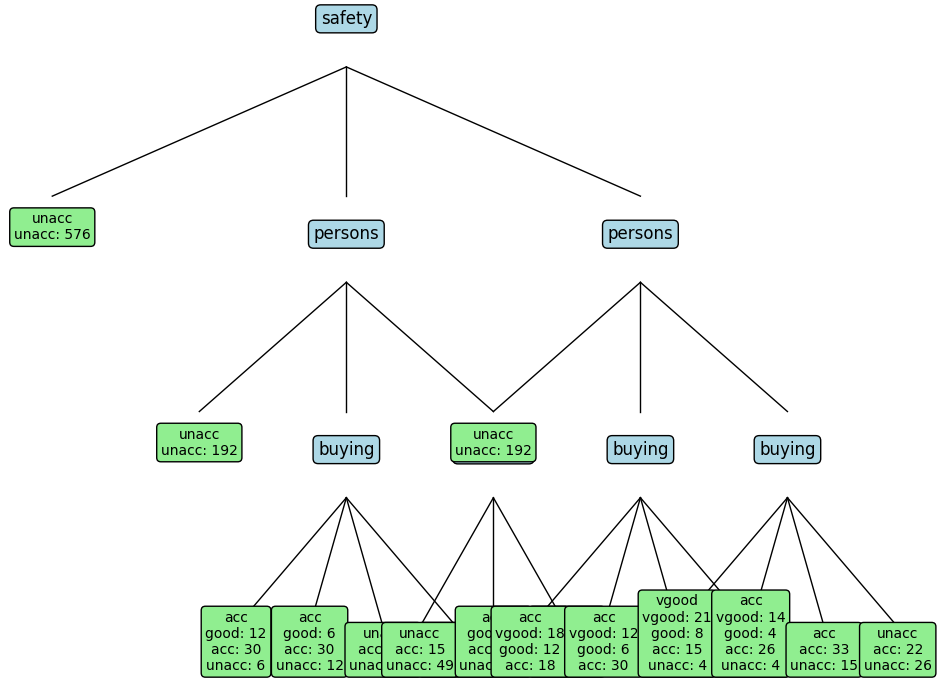

In [21]:
# Visualize the decision tree
plt.figure(figsize=(14, 8))
plot_tree(tree, data=data, attribute_names=attribute_names)
